# Update Log

### 2023/2/27
* rewrite tokenizer by hugging face
* rewrite dataloader via yield and add key_padding_mask
* Tying weight between embedding and pre_softmax
* rewriting Transformer model via TransformerLayer


* add Label Smooth
* rewrite train() and evaluate    almost cause by BatchLoader and tokenizer

### 2023/2/28
* rewrite BatchLoader make the total batch_tokens <= max_len
* merge valid_loader and train_loader to one function by argument dataset
* writer translate function for test
* carry BatchLoader in dataLoader of torch (by batch_size=1)
* change de -> en to de<->en(intertranslation)
* limited the max_len of output <= input length + 50
* in evaluate function,delete the tokens following \<eos>

# Future
### Test module
* beam search


### Train module
* use colossal-ai to train model (data parallel and gradient accumulation)



In [1]:
import numpy as np
import torch
import random
import os

seed_value = 721

np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value) 
torch.manual_seed(seed_value)    
torch.cuda.manual_seed(seed_value)      
# torch.cuda.manual_seed_all(seed_value)   

torch.backends.cudnn.benchmark = False        # if benchmark=True, deterministic will be False
torch.backends.cudnn.deterministic = True

/data2/zrs/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
device

device(type='cuda', index=2)

# Download dataset and preprocess

In [13]:
import torch

n_tokens = 37000
bos_id = 0
eos_id = 1
pad_id = 2

# below two hypeparameter is not need
# seq_len = 512
# batch_size = 8

d_model = 512
nhead = 8
dff = 2048
N = 6 # num of encoder/decoder layers
p_drop = 0.1

epsilon = 0.1

gpu_num = 1
warmup_steps = 4000*8//gpu_num

used_cuda = "cuda:2"
device = torch.device(used_cuda if torch.cuda.is_available() else "cpu")


save_path = "checkpoint.tar"

# other parameter in train() and spm.SentencePieceTrainer.train()


In [2]:
# from datasets import load_dataset
# dataset = load_dataset("wmt14", 'de-en', split='train')

# with open("en.txt",'w') as f:
#     for i in range(len(dataset)):
#         f.write(dataset[i]['translation']['en']+'\n')
        
# with open("de.txt",'w') as f:
#     for i in range(len(dataset)):
#         f.write(dataset[i]['translation']['de']+'\n')

In [3]:
# dataset.save_to_disk('dataset')

# load dataset to memory

### truncate the long sentence (though we can train transformer by any length ,the gpu memory cannot allow)

In [5]:
from datasets import load_from_disk
dataset = load_from_disk('dataset')

de_en_pairs = []
for i in range(len(dataset)):        
    de_en_pairs.append((dataset[i]['translation']['de'][:512],dataset[i]['translation']['en'][:512]))

In [6]:
de_en_pairs = sorted(de_en_pairs,key=lambda x:+len(x[0])+len(x[1]))

In [7]:
# len(de_en_pairs[-1][0])+len(de_en_pairs[-1][1])

In [8]:
# len(de_en_pairs[-500][0])+len(de_en_pairs[-500][1])

In [9]:
# de_en_pairs = de_en_pairs[:-500]

In [10]:
len(de_en_pairs[-1][0])+len(de_en_pairs[-1][1])

1024

In [11]:
print(len(de_en_pairs[0][0])+len(de_en_pairs[0][1]))
# print(len(de_en_pairs[1500][0])+len(de_en_pairs[1500][1]))
# de_en_pairs = de_en_pairs[1500:]
# print(len(de_en_pairs[0][0])+len(de_en_pairs[0][1]))

2


# Valid Dataloader  input:[S,B],mask:[B,S]

In [12]:
from datasets import load_dataset
valid_dataset = load_dataset("wmt14", 'de-en', split='validation')

valid_de_en_pairs = []
for i in range(len(valid_dataset)):
    valid_de_en_pairs.append((valid_dataset[i]['translation']['de'],valid_dataset[i]['translation']['en']))

Found cached dataset wmt14 (/data2/zrs/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


# Batchloader input:[S,B],mask:[B,S]

In [6]:
import torch
import numpy as np
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("tokenizer.json")
def batch_generator(dataset,gpu_num=1,max_len=1500):
    en_cnt = 0
    de_cnt = 0
    en_batch = []
    de_batch = []
    batch_size = 0
    for pairs in dataset:
        
        en_batch.append(pairs[1])
        de_batch.append(pairs[0])
        en_cnt += len(pairs[1])
        de_cnt += len(pairs[0])
        batch_size += 1
        
        if batch_size%gpu_num == 0:          
            if en_cnt + de_cnt > max_len*gpu_num:

                en_output = tokenizer.encode_batch(en_batch[:-gpu_num])
                de_output = tokenizer.encode_batch(de_batch[:-gpu_num])
                
                
                en_ids = [] 
                de_ids = []
                target_en_ids = []
                target_de_ids = []
                en_padding_mask = []
                de_padding_mask = []

                for en in en_output:
                    en_ids.append(en.ids)
                    target_en_ids.append(en.ids[1:]+[pad_id])
                    en_padding_mask.append(en.attention_mask)
                    
                for de in de_output:
                    de_ids.append(de.ids)
                    target_de_ids.append(de.ids[1:]+[pad_id])
                    de_padding_mask.append(de.attention_mask)              

                yield torch.LongTensor(en_ids).t().contiguous(),\
                        torch.LongTensor(de_ids).t().contiguous(),\
                        torch.LongTensor(target_en_ids).t().contiguous(),\
                        torch.LongTensor(target_de_ids).t().contiguous(),\
                        torch.BoolTensor(1-np.array(en_padding_mask)),\
                        torch.BoolTensor(1-np.array(de_padding_mask))
            

                en_cnt = 0
                de_cnt = 0            
                en_batch = en_batch[-gpu_num:]
                de_batch = de_batch[-gpu_num:]            

    if en_ids:
        yield torch.LongTensor(en_ids).t().contiguous(),\
                torch.LongTensor(de_ids).t().contiguous(),\
                torch.LongTensor(target_en_ids).t().contiguous(),\
                torch.LongTensor(target_de_ids).t().contiguous(),\
                torch.BoolTensor(1-np.array(en_padding_mask)),\
                torch.BoolTensor(1-np.array(de_padding_mask))
    

# Dataset

In [7]:
import torch
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self,dataset):
        self.data = dataset
    
    def __getitem__(self,index):
        example = self.data[index]
        return example[0],example[1],example[2],example[3],example[4],example[5]
    
    def __len__(self):
        return len(self.data)

# original data

In [15]:
train_list = [batch for batch in batch_generator(dataset=de_en_pairs,gpu_num=gpu_num)]
valid_list = [batch for batch in batch_generator(dataset=valid_de_en_pairs,gpu_num=gpu_num)]

In [16]:
train_dataset = FoodDataset(train_list)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=True)

valid_dataset = FoodDataset(valid_list)
valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=1,shuffle=False)

# pytorch Transfomer(by Layer)

In [8]:
from torch import nn
import torch
import math
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerDecoder

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = p_drop, max_len: int = 40000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

### activation, encoder key padding_mask and decoder key padding mask differnt with paper

In [10]:
class TransformerModel(nn.Module):
    def __init__(self,ntoken=n_tokens,d_model=d_model):
        super().__init__()
        
        self.d_model = d_model
        
        self.emb = nn.Embedding(ntoken,d_model,padding_idx=pad_id)
        self.pos_encoding = PositionalEncoding(d_model)
        
        encoder_layer = TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.encoder = TransformerEncoder(encoder_layer,N)
        
        decoder_layer = TransformerDecoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.decoder = TransformerDecoder(decoder_layer,N)
    
    def forward(self,src,tgt,tgt_mask,src_key_padding_mask,tgt_key_padding_mask):
        # src:[S,B] tgt:[T,B] tgt_mask:[T,T] src_key_padding_mask:[N,S] tgt_key_padding_mask:[N,T]
        # E=d_model
        src_emb = self.emb(src)*math.sqrt(self.d_model)  #src:[S,B] -> src_emb:[S,B,E]
        tgt_emb = self.emb(tgt)*math.sqrt(self.d_model)  #tgt:[T,B] -> tgt_emb:[T,B,E]
        src_emb = self.pos_encoding(src_emb)
        tgt_emb = self.pos_encoding(tgt_emb)
        
        # emb = embedding*sqrt(d_model) + PosEmbedding : [S,B,E]
        # tgt_mask:[T,T]
        
        src_hidden = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask) #[S,B,E]
        
        tgt_hidden = self.decoder(tgt_emb,src_hidden,tgt_mask=tgt_mask,\
                                  memory_key_padding_mask=src_key_padding_mask,\
                                  tgt_key_padding_mask=tgt_key_padding_mask) #[T,B,E]
                                 
        
        return F.linear(tgt_hidden,self.emb.weight) # Tying Weight [T,B,ntokens]

# Train
* de->en

In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_id,label_smoothing=epsilon) # Label Smooth
transformer_model = TransformerModel()
transformer_model.to(device)
print(transformer_model)

TransformerModel(
  (emb): Embedding(37000, 512, padding_idx=2)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_featur

In [21]:
# for i in range(1000):
#     optimizer.step()
#     scheduler.step()
#     print(scheduler.get_last_lr())

In [22]:
# ! pip install fvcore -i https://pypi.tuna.tsinghua.edu.cn/simple

In [23]:
from fvcore.nn import FlopCountAnalysis, parameter_count_table
print(parameter_count_table(transformer_model))

| name                | #elements or shape   |
|:--------------------|:---------------------|
| model               | 63.1M                |
|  emb                |  18.9M               |
|   emb.weight        |   (37000, 512)       |
|  encoder            |  18.9M               |
|   encoder.layers    |   18.9M              |
|    encoder.layers.0 |    3.2M              |
|    encoder.layers.1 |    3.2M              |
|    encoder.layers.2 |    3.2M              |
|    encoder.layers.3 |    3.2M              |
|    encoder.layers.4 |    3.2M              |
|    encoder.layers.5 |    3.2M              |
|  decoder            |  25.2M               |
|   decoder.layers    |   25.2M              |
|    decoder.layers.0 |    4.2M              |
|    decoder.layers.1 |    4.2M              |
|    decoder.layers.2 |    4.2M              |
|    decoder.layers.3 |    4.2M              |
|    decoder.layers.4 |    4.2M              |
|    decoder.layers.5 |    4.2M              |


# Checkpoint setting

In [24]:
def save_checkpoint(path,
                    epoch,
                    modules,
                    optimizers,
                    schedulers,
                    step_list,
                    train_loss_list,
                    val_loss_list,
                    safe_replacement: bool = True):

    if isinstance(modules, torch.nn.Module):
        modules = [modules]
    if isinstance(optimizers, torch.optim.Optimizer):
        optimizers = [optimizers]
    if not isinstance(schedulers, list):
        schedulers = [schedulers]
    # Data dictionary to be saved
    data = {
        'epoch': epoch,
        # Current time (UNIX timestamp)
        'time': time.time(),
        # State dict for all the modules
        'modules': [m.state_dict() for m in modules],
        # State dict for all the optimizers
        'optimizers': [o.state_dict() for o in optimizers],
        'schedulers': [s.state_dict() for s in schedulers],
        "step_list":step_list,
        "train_loss_list":train_loss_list,
        "val_loss_list":val_loss_list
    }

    # Safe replacement of old checkpoint

    if os.path.exists(path) and safe_replacement:
        # There's an old checkpoint. Rename it!
        temp_file = path + '.old'
        abandon_file = path + '.abandon'
        
        if os.path.exists(temp_file):
            os.rename(temp_file,abandon_file)
        
        os.rename(path, temp_file)
        
        if os.path.exists(abandon_file):
            os.unlink(abandon_file)
        
        

    # Save the new checkpoint
    with open(path, 'wb') as fp:
        torch.save(data, fp)
        # Flush and sync the FS
        fp.flush()
        os.fsync(fp.fileno())

    print("save to ",path)


In [25]:
from datetime import datetime
def load_checkpoint(path,
                    default_epoch,
                    modules,
                    optimizers,
                    schedulers,
                    step_list,
                    train_loss_list,
                    val_loss_list,
                    verbose: bool = True):

    if isinstance(modules, torch.nn.Module):
        modules = [modules]
    if isinstance(optimizers, torch.optim.Optimizer):
        optimizers = [optimizers]
    if not isinstance(schedulers, list):
        schedulers = [schedulers]
        
    # If there's a checkpoint
    if os.path.exists(path):
        # Load data
        data = torch.load(path, map_location=next(modules[0].parameters()).device)

        # Inform the user that we are loading the checkpoint
        if verbose:
            print(f"Loaded checkpoint saved at {datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d %H:%M:%S')}. "
                  f"Resuming from epoch {data['epoch']}")

        # Load state for all the modules
        for i, m in enumerate(modules):
            modules[i].load_state_dict(data['modules'][i])

        # Load state for all the optimizers
        for i, o in enumerate(optimizers):
            optimizers[i].load_state_dict(data['optimizers'][i])

        for i, s in enumerate(schedulers):
            schedulers[i].load_state_dict(data['schedulers'][i])
            
        step_list.clear()
        step_list += data['step_list']
        
        train_loss_list.clear()
        train_loss_list += data['train_loss_list']        
        
        val_loss_list.clear()
        val_loss_list += data['val_loss_list']
        
        # Next epoch
        return data['epoch'] + 1
    else:
        return default_epoch

# Train (train de<=>en i.e intertranslation)

In [19]:
def generate_square_subsequent_mask(sz: int):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [27]:
# mask = generate_square_subsequent_mask(38481) #38481 is the max_len  occur too much memory 
# mask = mask.to(device)

In [28]:
# mask

In [29]:
import time
import os
from torch.optim.lr_scheduler import LambdaLR

def train(model,epoch):
    
    
    lambda1 = lambda step_num: min((step_num+1)**(-0.5),(step_num+1)*(warmup_steps**(-1.5)))
    optimizer = torch.optim.Adam(transformer_model.parameters(),lr=d_model**(-0.5),betas=(0.9,0.98),eps=1e-9)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

    loss_list = []
    valid_list = []
    step_list = []    

    steps = 0
    
    load_checkpoint(path=save_path,
                    default_epoch=epoch,
                    modules=model,
                    optimizers=optimizer,
                    schedulers=scheduler,
                    step_list=step_list,
                    train_loss_list=loss_list,
                    val_loss_list=valid_list)
                   
    if step_list:
        steps = step_list[-1]
    
    model.train()
    total_loss = 0.0
    log_interval = 2000
    start_time = time.time()


    for en_ids,de_ids,target_en_ids,target_de_ids,\
        en_padding_mask,de_padding_mask in train_loader:

        en_ids = en_ids.squeeze().to(device)
        de_ids = de_ids.squeeze().to(device)
        target_en_ids = target_en_ids.squeeze().to(device)
        target_de_ids = target_de_ids.squeeze().to(device)
        en_padding_mask = en_padding_mask.squeeze().to(device)
        de_padding_mask = de_padding_mask.squeeze().to(device)
        
#         print(en_ids.shape,de_ids.shape,en_padding_mask.shape)
        # en_ids:[T,B],de_ids:[S,B],target_en_ids:[T,B],target_de_ids:[S,B]
        # en_padding_mask:[B,T] de_padding_mask:[B,S]
        
        # mask_slide:[T,T]
        #target_de_ids:$de<eos> en_ids:<bos>$en<eos>
#         output = model(target_de_ids,en_ids,mask[:en_ids.shape[0]][:en_ids.shape[0]])


        # de -> en
        #de_ids:$<bos>de<eos> en_ids:<bos>$en<eos>
        output = model(de_ids,en_ids,\
                       generate_square_subsequent_mask(en_ids.shape[0]).to(device),\
                       de_padding_mask,en_padding_mask)
                       
        # output:[T,B,ntokens]

        loss = 0.5*criterion(output.view(-1,n_tokens),target_en_ids.view(-1))
        
        
        output = model(en_ids,de_ids,\
                       generate_square_subsequent_mask(de_ids.shape[0]).to(device),\
                       en_padding_mask,de_padding_mask)
                       

        loss += 0.5*criterion(output.view(-1,n_tokens),target_de_ids.view(-1))       
        
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        
        steps += 1
        total_loss += loss.item()
        if steps%log_interval ==0:
            lr = scheduler.get_last_lr()[0]
            s_per_step = (time.time() - start_time) / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| steps {steps:5d}|'
                  f'lr {lr} | s/step {s_per_step:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()
            
            loss_list.append(cur_loss)
            step_list.append(steps)
            valid_list.append(evaluate(model,valid_loader))
            
            save_checkpoint(path=save_path,
                    epoch=epoch,
                    modules=model,
                    optimizers=optimizer,
                    schedulers=scheduler,
                    step_list=step_list,
                    train_loss_list=loss_list,
                    val_loss_list=valid_list)
                    

    save_checkpoint(path=save_path,
            epoch=epoch,
            modules=model,
            optimizers=optimizer,
            schedulers=scheduler,
            step_list=step_list,
            train_loss_list=loss_list,
            val_loss_list=valid_list)       

# Evaluate (only test de->en)

In [30]:
import numpy as np
from torchtext.data.metrics import bleu_score

def evaluate(model, valid_loader):
    print('='*30)
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    cnt=0
    pred_token_list = []
    en_token_list = []   
    
    flag = 1
    with torch.no_grad():

        for en_ids,de_ids,target_en_ids,target_de_ids,\
            en_padding_mask,de_padding_mask in valid_loader:
            
            en_ids = en_ids.squeeze().to(device)
            de_ids = de_ids.squeeze().to(device)
            target_en_ids = target_en_ids.squeeze().to(device)
            target_de_ids = target_de_ids.squeeze().to(device)
            en_padding_mask = en_padding_mask.squeeze().to(device)
            de_padding_mask = de_padding_mask.squeeze().to(device)

            
            # en_ids:[T,B],de_ids:[S,B],target_en_ids:[T,B],target_de_ids:[S,B]
            # en_padding_mask:[B,T] de_padding_mask:[B,S]

            # mask_slide:[T,T]
            #target_de_ids:$de<eos> en_ids:<bos>$en<eos>
    #         output = model(target_de_ids,en_ids,mask[:en_ids.shape[0]][:en_ids.shape[0]])

    
            # de -> en
            #de_ids:$<bos>de<eos> en_ids:<bos>$en<eos>
            output = model(de_ids,en_ids,\
                           generate_square_subsequent_mask(en_ids.shape[0]).to(device),\
                           de_padding_mask,en_padding_mask)

            # output:[T,B,ntokens]
            # target_en_ids:[T,B]

            loss = criterion(output.view(-1,n_tokens),target_en_ids.view(-1))
        
            
            total_loss += en_ids.shape[1]*loss.item() #B*mean_loss
            cnt += en_ids.shape[1]
            
            pred = torch.argmax(output,dim=-1)
            # pred[T,B]  target_en_ids[T,B]  tokens_id
            
            pred = pred.t()
            target_en_ids = target_en_ids.t()
            # pred[B,T]  target_en_ids[B,T]  tokens_id            
            
            
            sents = tokenizer.decode_batch(pred.tolist())
            #[B,T(id)] ->[B(str)] 
            if flag:
                print(sents[0])
            
    
            pred_output = tokenizer.encode_batch(sents)
            for o in pred_output:
                #o.tokens :[T(str)]
                
                token_list = []
                for token in o.tokens:
                    if token == eos_id:
                        break
                    token_list.append(token)
                pred_token_list.append(token_list)
                # pred_token_list [allB,T(str)]
            
            true_sents = tokenizer.decode_batch(target_en_ids.tolist())
            #[B,T(id)] -> [B(str)] 
            if flag:
                print(true_sents[0])
                flag=0
            
            
            target_output = tokenizer.encode_batch(true_sents) 
            for o in target_output:
                #o.tokens :[T(str)]
                en_token_list.append([o.tokens])
                # en_token_list [allB,1,T(str)]
            
    
    avg_loss = total_loss/cnt
    print(f"valid_loss:{avg_loss:.5f}")
    
#     print(len(pred_token_list),len(en_token_list))
    bleu = bleu_score(pred_token_list,en_token_list)
    print(f"bleu:{bleu}")
    
#     # pred_token_list [allB,T(str)] # en_token_list [allB,1,T(str)]
#     print(pred_token_list[0][:20],en_token_list[0])
        
    
    model.train()
    return avg_loss

In [40]:
for i in range(1,10):
    train(transformer_model,epoch=i)

Loaded checkpoint saved at 2023-02-28 21:16:26. Resuming from epoch 1
| steps  8000|lr 6.177095595460744e-05 | s/step  0.09 | loss 11.83 | ppl 137331.38
 The.... be... und.. the......................
 A Republican strategy to counter the re-election of Obama
valid_loss:9.68026
bleu:0.2711612468859339
save to  checkpoint.tar


KeyboardInterrupt: 

# Load model

In [32]:
# transformer_model.load_state_dict(torch.load("latest.pt"))

# Vision

In [33]:
# !pip install matplotlib

total steps: 8092000


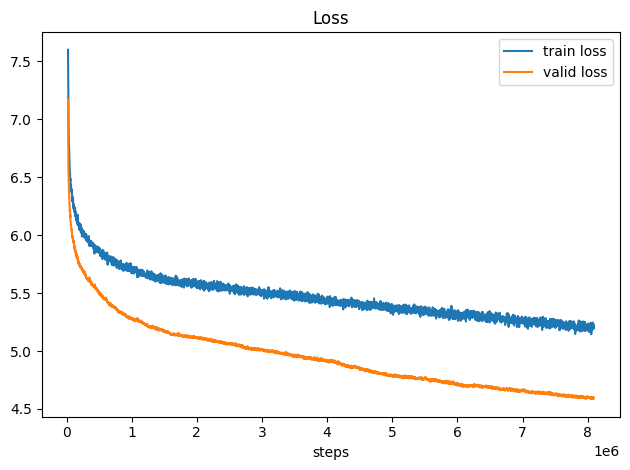

In [25]:
import matplotlib.pyplot as plt
import os

def paint():
    
    if os.path.exists(save_path):
        
        load_info = torch.load(save_path, map_location={'cuda:3': 'cuda:1'})
        loss_list = load_info["train_loss_list"]
        valid_list = load_info["val_loss_list"]
        step_list = load_info["step_list"]
        steps = step_list[-1]

    else :
        return "Not exist checkpoint"
    
    print("total steps:",steps)
    
    plt.title("Loss")
    plt.xlabel("steps")
    # plt.ylabel("loss")
    plt.plot(step_list[10:],loss_list[10:])
    plt.plot(step_list[10:],valid_list[10:])
    plt.legend(["train loss","valid loss"])


    plt.tight_layout()

paint()

# Test

In [4]:
from datasets import load_dataset
test_dataset = load_dataset("wmt14", 'de-en', split='test')

test_de_en_pairs = []
for i in range(len(test_dataset)):
    test_de_en_pairs.append((test_dataset[i]['translation']['de'],test_dataset[i]['translation']['en']))
    


Found cached dataset wmt14 (/data2/zrs/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


In [16]:
import os

criterion = nn.CrossEntropyLoss(ignore_index=pad_id) 
transformer_model = TransformerModel()
transformer_model.to(device)
if os.path.exists(save_path):

    data = torch.load(save_path, map_location={'cuda:3': 'cuda:1'})
    transformer_model.load_state_dict(data['modules'][0])

# evaluate(transformer_model,batch_generator(dataset=test_de_en_pairs,gpu_num=gpu_num))

NameError: name 'evaluate' is not defined

In [30]:
def translate(src,references):
    # src:str
    output = tokenizer.encode(src)
    
    src_ids = [output.ids] #[1,S] 
    src_padding_mask = [1-np.array(output.attention_mask)] #[1,S]
    tgt_ids = [[bos_id]] #[1,1] i.e [1,T]
    
    while tgt_ids[0][-1] != eos_id:
        if len(tgt_ids[0]) > len(output.ids) +50:
            break
        pred= transformer_model(torch.LongTensor(src_ids).t().contiguous().to(device),
                                torch.LongTensor(tgt_ids).t().contiguous().to(device),
                                generate_square_subsequent_mask(len(tgt_ids[0])).to(device),
                                torch.LongTensor(src_padding_mask).to(device),None)
        # [T,1,E]
        
        next_token = pred.argmax(dim=-1)[-1]
        #                      [T,1]
        
        # tgt_ids :<bos>       A         :[T]
        # pred    :  A    <next token>   :[T]
        
        tgt_ids[0].append(next_token.item())
    
    # src_ids:[S] tgt_ids=[T]
    tgt = tokenizer.decode(tgt_ids[0])
#     print("\nsrc:",src)
#     print("\npred:",tgt)
    #  candidate [allB,T(str)] # references [allB,1,T(str)]
    
    output = tokenizer.encode(tgt)
    candidate = [output.tokens]
    bleu = bleu_score(candidate,references)*100
#     print(f"\nbleu:{bleu}")
    return bleu

In [36]:
from torchtext.data.metrics import bleu_score

total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
#     print("="*40)
    output = tokenizer.encode(test_de_en_pairs[i][1])
    total_bleu += translate(test_de_en_pairs[i][0],references=[[output.tokens]])
#     print("ans:",test_de_en_pairs[i][1])

# print(total_bleu/len(test_de_en_pairs))


In [37]:
# total_bleu